In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
import keras

# for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


In [2]:
path = "../out/"
path_class_weights_df = "../data/grouped_15_rm_DesSc_FieExp_LabExp_Panel_STANDARDIZED.csv"
path_corpus = "../data/01_fuzzy_matched_corpus.jsonl"

num_classes = 15

maxlen = 30000 # max nr of words per document
max_words = 100000 # max vocab size

epochs = 50
batch_size = 24

## Preprocessing

In [3]:
grouped_rm = pd.read_csv(path_class_weights_df)
grouped_rm

,RM_tidy,count,class_weight
0,Action Research,21,151.809524
1,Case Study,402,7.930348
2,Conceptual,849,3.755006
3,Data Analytics,162,19.679012
4,Ethnography,15,212.533333
5,Experiment,280,11.385714
6,Field Study,331,9.631420
7,Literature Analysis,16,199.250000
8,Literature Review,153,20.836601
9,Opinion,115,27.721739


In [4]:
class_weights = grouped_rm['class_weight'].values
class_weights

array([151.80952381,   7.93034826,   3.75500589,  19.67901235,
       212.53333333,  11.38571429,   9.63141994, 199.25      ,
        20.83660131,  27.72173913,  11.76383764,  37.50588235,
        69.30434783,   7.41395349, 265.66666667])

In [5]:
dict_class_weights = {}
for i in enumerate(class_weights):
    dict_class_weights.update( {i[0] : i[1]} )

dict_class_weights

{0: 151.80952380952382,
 1: 7.930348258706468,
 2: 3.755005889281508,
 3: 19.679012345679013,
 4: 212.53333333333333,
 5: 11.385714285714286,
 6: 9.63141993957704,
 7: 199.25,
 8: 20.836601307189547,
 9: 27.721739130434784,
 10: 11.763837638376383,
 11: 37.50588235294118,
 12: 69.30434782608695,
 13: 7.413953488372092,
 14: 265.6666666666667}

In [6]:
fuzzy_df = pd.read_json(path_corpus, lines=True)
fuzzy_df.tail(12)

,fulltext,rm
0,From technical to sociotechnical change: tackl...,[Other]
1,"development: agency, institutions, and largesc...","[Case Study, Conceptual]"


In [7]:
fuzzy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 2 columns):
fulltext    1377 non-null object
rm          1377 non-null object
dtypes: object(2)
memory usage: 21.6+ KB


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = max_words, lower=True)
tokenizer.fit_on_texts(fuzzy_df.fulltext)

def get_features(text):
    """
    transforms text data to feature_vectors that can be used in the ml model.
    tokenizer must be available.
    """
    sequences = tokenizer.texts_to_sequences(text)
    return pad_sequences(sequences, maxlen = maxlen)

x = get_features(fuzzy_df.fulltext)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 185986 unique tokens.


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(fuzzy_df.rm)
labels = multilabel_binarizer.classes_
labels

array(['Action Research', 'Case Study', 'Conceptual', 'Data Analytics',
       'Ethnography', 'Experiment', 'Field Study', 'Literature Analysis',
       'Literature Review', 'Opinion', 'Other', 'Prototype', 'Simulation',
       'Survey', 'Tutorial'], dtype=object)

In [10]:
labels.shape

(15,)

In [11]:
from sklearn.model_selection import train_test_split

y = multilabel_binarizer.transform(fuzzy_df.rm)
print(y.shape)
x_train, x_valid, y_train, y_valid = train_test_split(x, 
                                                      y, 
                                                      test_size=0.3, 
                                                      random_state=0)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid, 
                                                    y_valid, 
                                                    test_size=0.33, 
                                                    random_state=0)

print("Shape of array in train: " + str(x_train.shape) + 
      ", valid: " + str(x_valid.shape) + 
      ", test: " + str(x_test.shape)) # 70-20-10%

(1377, 15)
Shape of array in train: (963, 30000), valid: (277, 30000), test: (137, 30000)


In [12]:
# sanity check
y_train

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 1, 0]])

In [13]:
# sanity check
x_train

array([[  0,   0,   0, ..., 218, 353, 257],
       [  0,   0,   0, ..., 218, 353, 257],
       [  0,   0,   0, ...,   8, 130,  40],
       ...,
       [  0,   0,   0, ...,  21, 270, 243],
       [  0,   0,   0, ..., 218, 353, 257],
       [  0,   0,   0, ..., 218, 353, 257]], dtype=int32)

In [14]:
len(x_train[0]) # each paper has been padded to maxlen of tokens

30000

## Model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, SeparableConv1D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

nr_of_filters = 500

model = Sequential()

# maxlen = 30000 # max nr of words per paper => padding created up to this nr
# max_words = 100000 # max vocab size, aka max nr of features
model.add(Embedding(max_words, output_dim = 400, input_length = maxlen))
model.add(Dropout(0.15))

# 1D convolution layer: the input is convolved with the filter (=convolutional kernel, window) over the temporal dimension
model.add(SeparableConv1D(filters = nr_of_filters, 
                 kernel_size = 3, # specifies length of 1D convolution window.
                 padding = 'valid', # means "no padding"
                 activation = 'relu', 
                 strides = 1))

model.add(Dropout(0.05))

model.add(GlobalMaxPool1D())

model.add(Dropout(0.15))

model.add(Dense(num_classes, activation = 'sigmoid'))

# model.add(BatchNormalization())
# model.add(Activation('sigmoid'))

optimizer = Adam(lr=1e-2)

model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy', 
              metrics = ['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30000, 400)        40000000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 30000, 400)        0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 29998, 500)        201700    
_________________________________________________________________
dropout_2 (Dropout)          (None, 29998, 500)        0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 500)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7515      
Total para

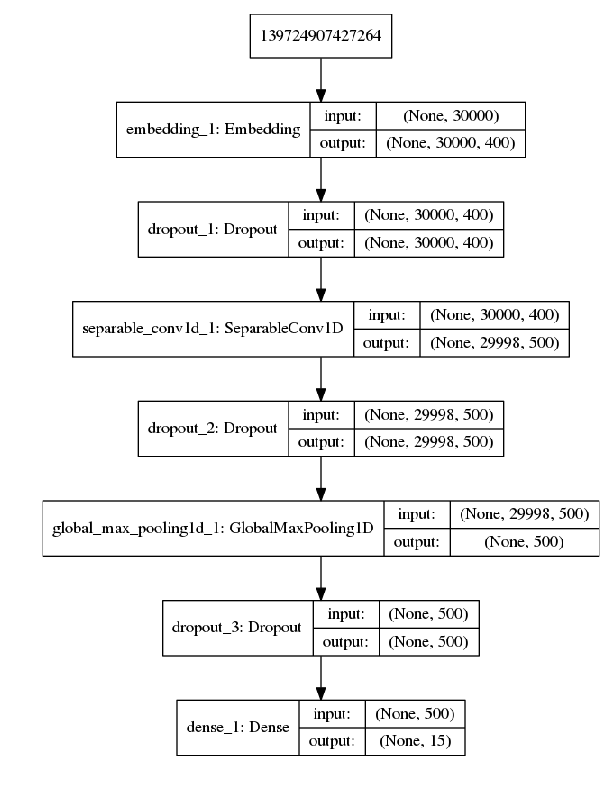

In [16]:
import pydot
from keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline
plot_model(model, 
           show_shapes=True, 
           to_file=path+'model_plot.png')

def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

display_image_in_actual_size(path+'model_plot.png')

In [17]:
callbacks = [ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                               factor=0.5, 
                               patience=3, 
                               min_delta=0.0001, 
                               min_lr=0.00000001),
# p.158: model may still be improving even if this isn’t reflected in AVG loss.
    
             EarlyStopping(monitor='loss', 
                  min_delta=0.0001, 
                  patience=5),
    
             ModelCheckpoint(filepath=path+'best_model_checkpoint.h5', 
                    monitor='val_categorical_accuracy',
                    save_best_only=True)]

history = model.fit(x_train, 
                    y_train,
                    class_weight = dict_class_weights,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (x_valid, y_valid),
                    callbacks = callbacks)

Train on 963 samples, validate on 277 samples
Epoch 1/50
963/963 [==============================] - 38s 39ms/step - loss: 7.3021 - categorical_accuracy: 0.0789 - val_loss: 0.4051 - val_categorical_accuracy: 0.0505
Epoch 2/50
963/963 [==============================] - 26s 26ms/step - loss: 4.7738 - categorical_accuracy: 0.2357 - val_loss: 0.3155 - val_categorical_accuracy: 0.1047
Epoch 3/50
963/963 [==============================] - 25s 26ms/step - loss: 4.0227 - categorical_accuracy: 0.2949 - val_loss: 0.2789 - val_categorical_accuracy: 0.4549
Epoch 4/50
963/963 [==============================] - 25s 26ms/step - loss: 3.4170 - categorical_accuracy: 0.3718 - val_loss: 0.3020 - val_categorical_accuracy: 0.1805
Epoch 5/50
963/963 [==============================] - 25s 26ms/step - loss: 2.6265 - categorical_accuracy: 0.3863 - val_loss: 0.2729 - val_categorical_accuracy: 0.3249
Epoch 6/50
963/963 [==============================] - 25s 26ms/step - loss: 1.8680 - categorical_accuracy: 0.5130 

In [18]:
model.save(path+'full_model.h5') # for full training cycle

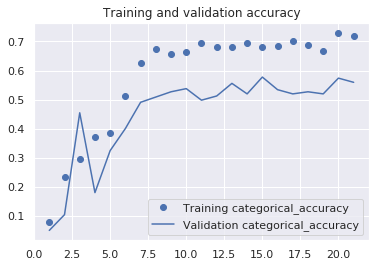

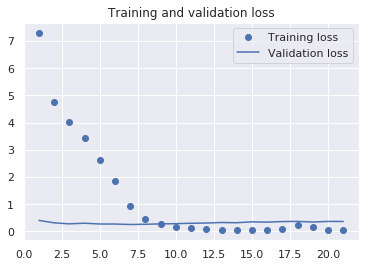

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training categorical_accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation categorical_accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Best model from Checkpoint

In [20]:
model = keras.models.load_model(path+'best_model_checkpoint.h5')
metrics = model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))
print("\n")
#________________________________________________________________________________
y_pred_train = model.predict(x_train)

threshold = 0.5
y_pred_train[y_pred_train >= threshold] = 1
y_pred_train[y_pred_train < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_train, y_pred_train, average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_train, y_pred_train, average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_train, y_pred_train, average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_train, y_pred_train)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_train, y_pred_train)})

classifier_metrics_train_df = pd.DataFrame.from_dict(data = classifier_metrics, orient='index', columns=['train'])

#________________________________________________________________________________
y_pred_valid = model.predict(x_valid)

y_pred_valid[y_pred_valid >= threshold] = 1
y_pred_valid[y_pred_valid < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_valid, y_pred_valid, average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_valid, y_pred_valid, average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_valid, y_pred_valid, average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_valid, y_pred_valid)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_valid, y_pred_valid)})

classifier_metrics_valid_df = pd.DataFrame.from_dict(data = classifier_metrics, orient='index', columns=['valid'])
#____________________________________________________________________________________
y_pred_test = model.predict(x_test)
print("Evaluation metrics on the train, valid and test set:")

y_pred_test[y_pred_test >= threshold] = 1
y_pred_test[y_pred_test < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_test, y_pred_test, average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_test, y_pred_test, average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_test, y_pred_test, average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_test, y_pred_test)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_test, y_pred_test)})

classifier_metrics_test_df = pd.DataFrame.from_dict(data = classifier_metrics, orient='index', columns=['test'])
#____________________________________________________________________________________
print("\n")
print("True nr of positive labels in the train set:       " + str(sum(y_train.astype(int))) + "\n" +
      "Predicted nr of positive labels for the train set: " + str(sum(y_pred_train.astype(int))))

print("\n")
print("True nr of positive labels in the valid set:       " + str(sum(y_valid.astype(int))) + "\n" +
      "Predicted nr of positive labels for the valid set: " + str(sum(y_pred_valid.astype(int))))

print("\n")
print("True nr of positive labels in the test set:       " + str(sum(y_test.astype(int))) + "\n" +
      "Predicted nr of positive labels for the test set: " + str(sum(y_pred_test.astype(int))))

results = pd.concat(objs = [classifier_metrics_train_df,
                            classifier_metrics_valid_df,
                            classifier_metrics_test_df], axis = 1)
results.to_csv(path+'results_best.csv',
                               index=True,
                               header=True)
test_statistics = pd.DataFrame([sum(y_train.astype(int)), sum(y_pred_train.astype(int)),
                                sum(y_valid.astype(int)), sum(y_pred_valid.astype(int)),
                                sum(y_test.astype(int)), sum(y_pred_test.astype(int))],
                               columns=labels,
                               index = ["TruePosTrain", "PredPosTrain",
                                       "TruePosValid", "PredPosValid",
                                        "TruePosTest", "PredPosTest"]).transpose()
test_statistics.loc['Average'] = test_statistics.mean().astype(int)
test_statistics.to_csv(path+'test_statistics_best.csv', index=True)

results
# Predictions generated.
# ====================
# Evaluation metrics on the train, valid and test set:
# train	valid	test
# precision	0.999419	0.753378	0.696774
# recall	0.999419	0.431335	0.455696
# f1_measure	0.999419	0.548585	0.551020
# hamming_loss	0.000138	0.088327	0.085645
# exact_match	0.998962	0.259928	0.240876

137/137 [==============================] - 1s 9ms/step
loss: 0.3833450809882505
categorical_accuracy: 0.49635036518103887


Evaluation metrics on the train, valid and test set:


True nr of positive labels in the train set:       [ 13 221 448 106   6 117 184  60  95  32 128  39  27 239   5]
Predicted nr of positive labels for the train set: [ 13 222 448 106   6 117 184  60  95  32 127  39  27 239   5]


True nr of positive labels in the valid set:       [  4  59 148  34   3  29  58  14  34   8  33  14   7  70   2]
Predicted nr of positive labels for the valid set: [  0  73 185  29   0  20  53  16  14   5  11   9   3  64   0]


True nr of positive labels in the test set:       [ 0 31 56 17  2 13 26 12 12  8 18  5  1 34  2]
Predicted nr of positive labels for the test set: [ 1 39 81 11  1  6 28 10  2  2  4  2  0 29  0]


,train,valid,test
precision,0.999419,0.647303,0.592593
recall,0.999419,0.603482,0.540084
f1_measure,0.999419,0.624625,0.565121
hamming_loss,0.000138,0.090253,0.095864
exact_match,0.998962,0.292419,0.262774


In [21]:
test_statistics

,TruePosTrain,PredPosTrain,TruePosValid,PredPosValid,TruePosTest,PredPosTest
Action Research,13,13,4,0,0,1
Case Study,221,222,59,73,31,39
Conceptual,448,448,148,185,56,81
Data Analytics,106,106,34,29,17,11
Ethnography,6,6,3,0,2,1
Experiment,117,117,29,20,13,6
Field Study,184,184,58,53,26,28
Literature Analysis,60,60,14,16,12,10
Literature Review,95,95,34,14,12,2
Opinion,32,32,8,5,8,2


## Full model: all epochs trained

In [22]:
model = keras.models.load_model(path+'full_model.h5')
metrics = model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))
print("\n")
#________________________________________________________________________________
y_pred_train = model.predict(x_train)

threshold = 0.5
y_pred_train[y_pred_train >= threshold] = 1
y_pred_train[y_pred_train < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_train, y_pred_train, average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_train, y_pred_train, average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_train, y_pred_train, average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_train, y_pred_train)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_train, y_pred_train)})

classifier_metrics_train_df = pd.DataFrame.from_dict(data = classifier_metrics, orient='index', columns=['train'])

#________________________________________________________________________________
y_pred_valid = model.predict(x_valid)

y_pred_valid[y_pred_valid >= threshold] = 1
y_pred_valid[y_pred_valid < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_valid, y_pred_valid, average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_valid, y_pred_valid, average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_valid, y_pred_valid, average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_valid, y_pred_valid)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_valid, y_pred_valid)})

classifier_metrics_valid_df = pd.DataFrame.from_dict(data = classifier_metrics, orient='index', columns=['valid'])
#____________________________________________________________________________________
y_pred_test = model.predict(x_test)
print("Evaluation metrics on the train, valid and test set:")

y_pred_test[y_pred_test >= threshold] = 1
y_pred_test[y_pred_test < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_test, y_pred_test, average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_test, y_pred_test, average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_test, y_pred_test, average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_test, y_pred_test)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_test, y_pred_test)})

classifier_metrics_test_df = pd.DataFrame.from_dict(data = classifier_metrics, orient='index', columns=['test'])
#____________________________________________________________________________________
print("\n")
print("True nr of positive labels in the train set:       " + str(sum(y_train.astype(int))) + "\n" +
      "Predicted nr of positive labels for the train set: " + str(sum(y_pred_train.astype(int))))

print("\n")
print("True nr of positive labels in the valid set:       " + str(sum(y_valid.astype(int))) + "\n" +
      "Predicted nr of positive labels for the valid set: " + str(sum(y_pred_valid.astype(int))))

print("\n")
print("True nr of positive labels in the test set:       " + str(sum(y_test.astype(int))) + "\n" +
      "Predicted nr of positive labels for the test set: " + str(sum(y_pred_test.astype(int))))

results = pd.concat(objs = [classifier_metrics_train_df,
                            classifier_metrics_valid_df,
                            classifier_metrics_test_df], axis = 1)
results.to_csv(path+'results_full.csv',
                               index=True,
                               header=True)
test_statistics = pd.DataFrame([sum(y_train.astype(int)), sum(y_pred_train.astype(int)),
                                sum(y_valid.astype(int)), sum(y_pred_valid.astype(int)),
                                sum(y_test.astype(int)), sum(y_pred_test.astype(int))],
                               columns=labels,
                               index = ["TruePosTrain", "PredPosTrain",
                                       "TruePosValid", "PredPosValid",
                                        "TruePosTest", "PredPosTest"]).transpose()
test_statistics.loc['Average'] = test_statistics.mean().astype(int)
test_statistics.to_csv(path+'test_statistics_full.csv', index=True)

results
# Predictions generated.
# ====================
# Evaluation metrics on the train, valid and test set:
# train	valid	test
# precision	0.999419	0.753378	0.696774
# recall	0.999419	0.431335	0.455696
# f1_measure	0.999419	0.548585	0.551020
# hamming_loss	0.000138	0.088327	0.085645
# exact_match	0.998962	0.259928	0.240876

137/137 [==============================] - 1s 5ms/step
loss: 0.3670517021287097
categorical_accuracy: 0.45985401481607535


Evaluation metrics on the train, valid and test set:


True nr of positive labels in the train set:       [ 13 221 448 106   6 117 184  60  95  32 128  39  27 239   5]
Predicted nr of positive labels for the train set: [ 13 220 448 106   6 117 184  60  95  32 127  39  27 239   5]


True nr of positive labels in the valid set:       [  4  59 148  34   3  29  58  14  34   8  33  14   7  70   2]
Predicted nr of positive labels for the valid set: [  1  61 169  36   0  20  47  16  19   8  17   8   5  63   0]


True nr of positive labels in the test set:       [ 0 31 56 17  2 13 26 12 12  8 18  5  1 34  2]
Predicted nr of positive labels for the test set: [ 2 36 66 17  0  6 22 12  4  2 10  2  0 30  1]


,train,valid,test
precision,1.000000,0.640426,0.623810
recall,0.998837,0.582205,0.552743
f1_measure,0.999418,0.609929,0.586130
hamming_loss,0.000138,0.092659,0.090024
exact_match,0.997923,0.285199,0.284672


In [23]:
test_statistics

,TruePosTrain,PredPosTrain,TruePosValid,PredPosValid,TruePosTest,PredPosTest
Action Research,13,13,4,1,0,2
Case Study,221,220,59,61,31,36
Conceptual,448,448,148,169,56,66
Data Analytics,106,106,34,36,17,17
Ethnography,6,6,3,0,2,0
Experiment,117,117,29,20,13,6
Field Study,184,184,58,47,26,22
Literature Analysis,60,60,14,16,12,12
Literature Review,95,95,34,19,12,4
Opinion,32,32,8,8,8,2
